In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
tracking1 = pd.read_csv('./data/nfl-big-data-bowl-2021/week1.csv')
tracking2 = pd.read_csv('./data/nfl-big-data-bowl-2021/week2.csv')
tracking3 = pd.read_csv('./data/nfl-big-data-bowl-2021/week3.csv')
tracking4 = pd.read_csv('./data/nfl-big-data-bowl-2021/week4.csv')
tracking5 = pd.read_csv('./data/nfl-big-data-bowl-2021/week5.csv')
tracking6 = pd.read_csv('./data/nfl-big-data-bowl-2021/week6.csv')
tracking7 = pd.read_csv('./data/nfl-big-data-bowl-2021/week7.csv')
tracking8 = pd.read_csv('./data/nfl-big-data-bowl-2021/week8.csv')
tracking9 = pd.read_csv('./data/nfl-big-data-bowl-2021/week9.csv')
tracking10 = pd.read_csv('./data/nfl-big-data-bowl-2021/week10.csv')
tracking11 = pd.read_csv('./data/nfl-big-data-bowl-2021/week11.csv')
tracking12 = pd.read_csv('./data/nfl-big-data-bowl-2021/week12.csv')
tracking13 = pd.read_csv('./data/nfl-big-data-bowl-2021/week13.csv')
tracking14 = pd.read_csv('./data/nfl-big-data-bowl-2021/week14.csv')
tracking15 = pd.read_csv('./data/nfl-big-data-bowl-2021/week15.csv')
tracking16 = pd.read_csv('./data/nfl-big-data-bowl-2021/week16.csv')
tracking17 = pd.read_csv('./data/nfl-big-data-bowl-2021/week17.csv')

df = pd.concat([tracking1,
                      tracking2,
                      tracking3,
                      tracking4,
                      tracking5,
                      tracking6,
                      tracking7,
                      tracking8,
                      tracking9,
                      tracking10,
                      tracking11,
                      tracking12,
                      tracking13,
                      tracking14,
                      tracking15,
                      tracking16,
                      tracking17
                     ], axis=0)

In [3]:
plays = pd.read_csv('./data/nfl-big-data-bowl-2021/plays.csv')
plays = plays[['gameId', 'playId', 'absoluteYardlineNumber']]

In [4]:
df['event'].unique()

array([nan, 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds', 'pass_outcome_incomplete',
       'first_contact', 'tackle', 'man_in_motion', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered', 'handoff',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'pass_shovel', 'line_set', 'shift', 'touchdown',
       'fumble_defense_recovered', 'pass_outcome_touchdown', 'run',
       'touchback', 'penalty_flag', 'penalty_accepted', 'qb_spike',
       'field_goal_blocked', 'punt_fake', 'snap_direct',
       'run_pass_option', 'pass_lateral', 'lateral', 'field_goal_fake',
       'huddle_start_offense', 'huddle_break_offense', 'timeout_home',
       'safety', 'field_goal_play'], dtype=object)

In [5]:
defense_positions = ['SS', 'FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DL', 'DB', 'NT', 'S', 'DE']
pass_caught_time = ['pass_outcome_caught']

# Get Targeted Receiver

In [6]:
target_receiver = df[df['event'].isin(pass_caught_time)]
ball_positions = target_receiver[target_receiver['nflId'].isna()][['gameId', 'playId', 'x', 'y']].rename(columns={'x': 'ball_x', 'y': 'ball_y'})
target_receiver = target_receiver.merge(ball_positions, on=['gameId', 'playId'], how='left')
target_receiver['distance_to_ball'] = np.sqrt((target_receiver['x'] - target_receiver['ball_x'])**2 + (target_receiver['y'] - target_receiver['ball_y'])**2)
target_receiver = target_receiver[~target_receiver['position'].isin(defense_positions)]
target_receiver = target_receiver[target_receiver['nflId'].notna()]
target_receiver = target_receiver[target_receiver['distance_to_ball'].notna()]
target_receiver = target_receiver.loc[target_receiver.groupby(['gameId', 'playId'])['distance_to_ball'].idxmin()][['gameId', 'playId', 'nflId', 'distance_to_ball']]
target_receiver = target_receiver.rename(columns={'nflId':'target_receiver_nflId'})
target_receiver = target_receiver.drop('distance_to_ball', axis=1)

In [7]:
target_receiver

,gameId,playId,target_receiver_nflId
2,2018090600,75,2495454.0
16,2018090600,190,2495454.0
36,2018090600,320,2552600.0
50,2018090600,492,2552453.0
67,2018090600,521,2555415.0
...,...,...,...
159375,2018123015,3653,2558856.0
159510,2018123015,3794,2561272.0
159554,2018123015,3819,2558208.0
159779,2018123015,4057,2553439.0


# Get Target Receiver Position When Ball Caught

In [8]:
pass_caught = df[df['event'].isin(pass_caught_time)]

In [9]:
pass_caught = pass_caught.merge(target_receiver, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'target_receiver_nflId'])

In [10]:
targeted_reciever_positions = pass_caught.groupby(['gameId', 'playId', 'target_receiver_nflId'])[['x', 'y', 's', 'a', 'dis', 'o', 'dir']].mean()

targeted_reciever_positions = targeted_reciever_positions.rename(columns={'x':'targeted_receiver_pass_caught_x', 
                                            'y':'targeted_receiver_pass_caught_y', 
                                            's':'targeted_receiver_pass_caught_s', 
                                            'a':'targeted_receiver_pass_caught_a', 
                                            'dis':'targeted_receiver_pass_caught_dis', 
                                            'o':'targeted_receiver_pass_caught_o', 
                                            'dir':'targeted_receiver_pass_caught_dir'})

targeted_receiver_info = target_receiver.merge(targeted_reciever_positions, 
                      left_on=['gameId', 'playId', 'target_receiver_nflId'], 
                      right_index=True)

In [11]:
targeted_receiver_info

,gameId,playId,target_receiver_nflId,targeted_receiver_pass_caught_x,targeted_receiver_pass_caught_y,targeted_receiver_pass_caught_s,targeted_receiver_pass_caught_a,targeted_receiver_pass_caught_dis,targeted_receiver_pass_caught_o,targeted_receiver_pass_caught_dir
2,2018090600,75,2495454.0,81.48,50.13,4.93,3.07,0.49,326.77,358.86
16,2018090600,190,2495454.0,22.84,8.70,7.57,2.57,0.78,165.15,228.30
36,2018090600,320,2552600.0,16.93,49.42,6.92,3.45,0.69,288.40,339.25
50,2018090600,492,2552453.0,51.39,8.57,5.87,2.29,0.58,261.83,246.69
67,2018090600,521,2555415.0,16.83,18.01,4.60,1.80,0.47,143.01,212.66
...,...,...,...,...,...,...,...,...,...,...
159375,2018123015,3653,2558856.0,86.95,1.39,0.59,0.50,0.06,266.03,118.54
159510,2018123015,3794,2561272.0,67.55,26.16,4.39,4.45,0.46,344.19,304.54
159554,2018123015,3819,2558208.0,54.31,18.33,1.63,2.36,0.16,45.85,13.31
159779,2018123015,4057,2553439.0,39.96,39.54,7.60,0.51,0.75,356.09,7.90


# Get Closest Defender

In [12]:
defense_positions_non_line = ['SS', 'FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DB', 'S']

In [13]:
pass_caught = df[df['event'].isin(pass_caught_time)]
pass_caught = pass_caught[pass_caught['position'].isin(defense_positions_non_line)]
pass_caught = pass_caught[pass_caught['nflId'].notna()]
pass_caught = pass_caught.merge(targeted_receiver_info, left_on=['gameId', 'playId'], right_on=['gameId', 'playId'])
pass_caught['closest_defender_distance_from_target_receiver'] = np.sqrt((pass_caught['x'] - pass_caught['targeted_receiver_pass_caught_x'])**2 + (pass_caught['y'] - pass_caught['targeted_receiver_pass_caught_y'])**2)
closest_defenders = pass_caught.loc[pass_caught.groupby(['gameId', 'playId'])['closest_defender_distance_from_target_receiver'].idxmin()][['gameId', 'playId', 'nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'closest_defender_distance_from_target_receiver', 'playDirection']]


In [14]:
closest_defenders = closest_defenders.rename(columns={
                               'nflId':'closest_defender_nflId',
                               'x':'closest_defender_pass_caught_x',
                               'y':'closest_defender_pass_caught_y',
                               's':'closest_defender_pass_caught_s',
                               'a':'closest_defender_pass_caught_a',
                               'dis':'closest_defender_pass_caught_dis',
                               'o':'closest_defender_pass_caught_o',
                               'dir':'closest_defender_pass_caught_dir'})

In [15]:
df['event'].unique()

array([nan, 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds', 'pass_outcome_incomplete',
       'first_contact', 'tackle', 'man_in_motion', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered', 'handoff',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'pass_shovel', 'line_set', 'shift', 'touchdown',
       'fumble_defense_recovered', 'pass_outcome_touchdown', 'run',
       'touchback', 'penalty_flag', 'penalty_accepted', 'qb_spike',
       'field_goal_blocked', 'punt_fake', 'snap_direct',
       'run_pass_option', 'pass_lateral', 'lateral', 'field_goal_fake',
       'huddle_start_offense', 'huddle_break_offense', 'timeout_home',
       'safety', 'field_goal_play'], dtype=object)

# Get Closest Blocker

In [16]:
df['position'].unique()

array(['QB', 'SS', 'WR', 'FS', 'RB', 'MLB', 'CB', 'TE', 'LB', 'FB', nan,
       'OLB', 'HB', 'ILB', 'DL', 'DB', 'NT', 'S', 'DE', 'P', 'LS', 'K',
       'DT'], dtype=object)

In [17]:
offense_positions_non_line = ['WR', 'TE', 'RB', 'HB']

In [18]:
pass_caught = df[df['event'].isin(pass_caught_time)]
pass_caught = pass_caught[pass_caught['position'].isin(offense_positions_non_line)]
pass_caught = pass_caught[pass_caught['nflId'].notna()]
pass_caught = pass_caught.merge(closest_defenders, left_on=['gameId', 'playId'], right_on=['gameId', 'playId'])
pass_caught = pass_caught.merge(targeted_receiver_info, left_on=['gameId', 'playId'], right_on=['gameId', 'playId'])
pass_caught['closest_blocker_distance_from_closest_defender'] = np.sqrt((pass_caught['x'] - pass_caught['closest_defender_pass_caught_x'])**2 + (pass_caught['y'] - pass_caught['closest_defender_pass_caught_y'])**2)
pass_caught = pass_caught[pass_caught['nflId'] != pass_caught['target_receiver_nflId']]
closest_blockers = pass_caught.loc[pass_caught.groupby(['gameId', 'playId'])['closest_blocker_distance_from_closest_defender'].idxmin()][['gameId', 'playId', 'nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'closest_blocker_distance_from_closest_defender']]


In [19]:
closest_blockers = closest_blockers.rename(columns={
                               'nflId':'closest_blocker_nflId',
                               'x':'closest_blocker_pass_caught_x',
                               'y':'closest_blocker_pass_caught_y',
                               's':'closest_blocker_pass_caught_s',
                               'a':'closest_blocker_pass_caught_a',
                               'dis':'closest_blocker_pass_caught_dis',
                               'o':'closest_blocker_pass_caught_o',
                               'dir':'closest_blocker_pass_caught_dir'})

In [20]:
closest_blockers

,gameId,playId,closest_blocker_nflId,closest_blocker_pass_caught_x,closest_blocker_pass_caught_y,closest_blocker_pass_caught_s,closest_blocker_pass_caught_a,closest_blocker_pass_caught_dis,closest_blocker_pass_caught_o,closest_blocker_pass_caught_dir,closest_blocker_distance_from_closest_defender
1,2018090600,75,2533040.0,76.75,36.60,2.82,1.85,0.28,33.31,332.72,13.440629
8,2018090600,190,2560854.0,41.91,10.06,2.28,1.12,0.23,295.30,315.55,18.601376
10,2018090600,320,2540158.0,18.00,41.93,4.17,1.26,0.42,311.50,353.87,7.191836
15,2018090600,492,2507828.0,47.05,22.66,5.09,1.68,0.50,280.58,231.10,8.142358
19,2018090600,521,2495454.0,7.73,22.85,5.57,4.14,0.57,147.50,174.33,9.893675
...,...,...,...,...,...,...,...,...,...,...,...
53591,2018123015,3653,2552430.0,95.10,8.19,1.74,1.32,0.18,255.71,311.29,7.997912
53636,2018123015,3794,2506106.0,73.18,29.03,4.72,1.62,0.48,249.56,237.01,5.563641
53651,2018123015,3819,2553435.0,67.24,14.53,2.95,2.72,0.31,308.58,208.64,14.467467
53725,2018123015,4057,2530747.0,52.94,35.82,6.75,2.30,0.68,337.37,30.89,7.733589


# Get Targeted Receiver Position When Play Ended

In [21]:
play_ended_events = ['tackle', 'out_of_bounds', 'fumble', 'touchdown', 'pass_outcome_touchdown']

In [22]:
play_ended = df[df['event'].isin(play_ended_events)]

In [23]:
play_ended = play_ended.merge(target_receiver, left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'target_receiver_nflId'])




In [24]:
play_ended = play_ended[['gameId', 'playId', 'target_receiver_nflId', 'x']]

In [25]:
play_ended = play_ended.rename(columns={'x':'x_play_ended'})

In [26]:
targeted_receiver_info

,gameId,playId,target_receiver_nflId,targeted_receiver_pass_caught_x,targeted_receiver_pass_caught_y,targeted_receiver_pass_caught_s,targeted_receiver_pass_caught_a,targeted_receiver_pass_caught_dis,targeted_receiver_pass_caught_o,targeted_receiver_pass_caught_dir
2,2018090600,75,2495454.0,81.48,50.13,4.93,3.07,0.49,326.77,358.86
16,2018090600,190,2495454.0,22.84,8.70,7.57,2.57,0.78,165.15,228.30
36,2018090600,320,2552600.0,16.93,49.42,6.92,3.45,0.69,288.40,339.25
50,2018090600,492,2552453.0,51.39,8.57,5.87,2.29,0.58,261.83,246.69
67,2018090600,521,2555415.0,16.83,18.01,4.60,1.80,0.47,143.01,212.66
...,...,...,...,...,...,...,...,...,...,...
159375,2018123015,3653,2558856.0,86.95,1.39,0.59,0.50,0.06,266.03,118.54
159510,2018123015,3794,2561272.0,67.55,26.16,4.39,4.45,0.46,344.19,304.54
159554,2018123015,3819,2558208.0,54.31,18.33,1.63,2.36,0.16,45.85,13.31
159779,2018123015,4057,2553439.0,39.96,39.54,7.60,0.51,0.75,356.09,7.90


# Get Label

In [27]:
data = closest_defenders.merge(targeted_receiver_info, on=['gameId', 'playId'])

In [28]:
data = data.merge(closest_blockers, on=['gameId', 'playId'])

In [29]:
data = data.merge(play_ended, on=['gameId', 'playId', 'target_receiver_nflId'])

In [30]:
data.loc[data['playDirection'] == 'left', 'YAC'] = (
    data['targeted_receiver_pass_caught_x'] - data['x_play_ended']
)

data.loc[data['playDirection'] == 'right', 'YAC'] = (
    data['x_play_ended'] - data['targeted_receiver_pass_caught_x']
)

In [31]:
data = data.merge(plays, on=['gameId', 'playId'])

In [32]:
data = data.dropna()

In [33]:
data['targeted_receiver_pass_caught_o_dir_diff'] = data['targeted_receiver_pass_caught_o'] - data['targeted_receiver_pass_caught_dir']
data['closest_defender_pass_caught_o_dir_diff'] = data['closest_defender_pass_caught_o'] - data['closest_defender_pass_caught_dir']
data['targeted_closest_dir_difference'] = data['closest_defender_pass_caught_dir'] - data['targeted_receiver_pass_caught_dir']
data['targeted_closest_o_difference'] = data['closest_defender_pass_caught_o'] - data['targeted_receiver_pass_caught_o']
data['targeted_closest_a_difference'] = data['closest_defender_pass_caught_a'] - data['targeted_receiver_pass_caught_a']
data['targeted_closest_s_difference'] = data['closest_defender_pass_caught_s'] - data['targeted_receiver_pass_caught_s']
data['targeted_closest_dis_difference'] = data['closest_defender_pass_caught_dis'] - data['targeted_receiver_pass_caught_dis']

In [34]:
receiver_dist_0 = abs(data['targeted_receiver_pass_caught_y'] - 0)
receiver_dist_53_3 = abs(data['targeted_receiver_pass_caught_y'] - 53.3)

defender_dist_0 = abs(data['closest_defender_pass_caught_y'] - 0)
defender_dist_53_3 = abs(data['closest_defender_pass_caught_y'] - 53.3)

blocker_dist_0 = abs(data['closest_blocker_pass_caught_y'] - 0)
blocker_dist_53_3 = abs(data['closest_blocker_pass_caught_y'] - 53.3)

data['targeted_receiver_distance_from_oob'] = np.minimum(receiver_dist_0, receiver_dist_53_3)
data['closest_defender_distance_from_oob'] = np.minimum(defender_dist_0, defender_dist_53_3)

data['closest_blocker_distance_from_oob'] = np.minimum(blocker_dist_0, blocker_dist_53_3)

In [35]:
data['closest_blocker_distance_from_target_receiver'] = np.sqrt((data['closest_blocker_pass_caught_x'] - data['targeted_receiver_pass_caught_x'])**2 + (data['closest_blocker_pass_caught_y'] - data['targeted_receiver_pass_caught_y'])**2)



# Model YAC

In [36]:
y = data['YAC']
X = data.drop(['gameId', 'playId', 'YAC', 'closest_defender_nflId', 'closest_blocker_nflId', 'target_receiver_nflId', 'playDirection', 'x_play_ended'], axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor()

param_grid = {
    'num_leaves': [31, 100],
    'learning_rate': [0.05, 0.2],
    'n_estimators': [50, 200],
    'max_depth': [5, 15],
    'min_data_in_leaf': [10, 30],
    'lambda_l1': [0.1],
    'lambda_l2': [0.1],
    'verbosity':[-1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='r2', cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2_Score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
R2_Score: 0.30164034328308864
Mean Squared Error: 39.025264770984144
Best Parameters: {'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 15, 'min_data_in_leaf': 10, 'n_estimators': 200, 'num_leaves': 31, 'verbosity': -1}
Best Cross-Validation Score: 0.3104300761761828


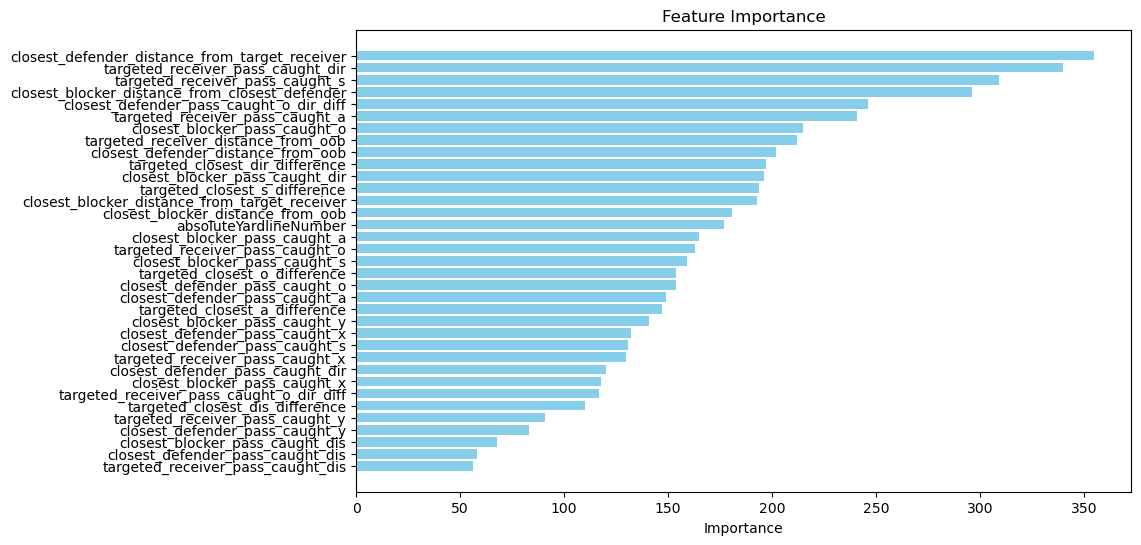

                                           Feature  Importance
7   closest_defender_distance_from_target_receiver         355
14               targeted_receiver_pass_caught_dir         340
10                 targeted_receiver_pass_caught_s         309
22  closest_blocker_distance_from_closest_defender         296
25         closest_defender_pass_caught_o_dir_diff         246
11                 targeted_receiver_pass_caught_a         241
20                   closest_blocker_pass_caught_o         215
31             targeted_receiver_distance_from_oob         212
32              closest_defender_distance_from_oob         202
26                 targeted_closest_dir_difference         197


In [38]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df.head(10))


In [39]:
X.columns

Index(['closest_defender_pass_caught_x', 'closest_defender_pass_caught_y',
       'closest_defender_pass_caught_s', 'closest_defender_pass_caught_a',
       'closest_defender_pass_caught_dis', 'closest_defender_pass_caught_o',
       'closest_defender_pass_caught_dir',
       'closest_defender_distance_from_target_receiver',
       'targeted_receiver_pass_caught_x', 'targeted_receiver_pass_caught_y',
       'targeted_receiver_pass_caught_s', 'targeted_receiver_pass_caught_a',
       'targeted_receiver_pass_caught_dis', 'targeted_receiver_pass_caught_o',
       'targeted_receiver_pass_caught_dir', 'closest_blocker_pass_caught_x',
       'closest_blocker_pass_caught_y', 'closest_blocker_pass_caught_s',
       'closest_blocker_pass_caught_a', 'closest_blocker_pass_caught_dis',
       'closest_blocker_pass_caught_o', 'closest_blocker_pass_caught_dir',
       'closest_blocker_distance_from_closest_defender',
       'absoluteYardlineNumber', 'targeted_receiver_pass_caught_o_dir_diff',
      

# Apply Model To All Time Frames

In [ ]:
# # Specify the gameId and playIds you want to test
# test_game_id = 2018090600  # Replace with the gameId you want to test
# test_play_ids = [75]  # Replace with the playIds you want to test

# Filter the dataframe to include only the selected gameId and playIds

weeks = [
          tracking1,
          tracking2,
          tracking3,
          tracking4,
          tracking5,
          tracking6,
          tracking7,
          tracking8,
          tracking9,
          tracking10,
          tracking11,
          tracking12,
          tracking13,
          tracking14,
          tracking15,
          tracking16,
          tracking17
        ]

for i, week in enumerate(weeks):
    
    print(f"week {i+1}")
    df = week.copy()

    # Filter receivers (e.g., WR) and defenders (e.g., CB)
    receivers = df[df['position'].isin(['WR', 'TE'])]
    defenders = df[df['position'].isin(defense_positions_non_line)]
    blockers = df[df['position'].isin(offense_positions_non_line)]
    
    # Initialize a list to store the data for the new dataframe
    data_for_new_df = []
    
    # Iterate through each frameId of the receiver and find the closest defender at each frameId
    for _, receiver in tqdm(receivers.iterrows(), total=receivers.shape[0], desc="Processing receivers"):
        # Filter defenders for the same gameId and playId as the receiver at the same frameId
        defenders_in_frame = defenders[(defenders['gameId'] == receiver['gameId']) & 
                                       (defenders['playId'] == receiver['playId']) & 
                                       (defenders['frameId'] == receiver['frameId'])]
    
        
        # Calculate the Euclidean distance between the receiver and all defenders at the same frameId
        distances = np.sqrt((defenders_in_frame['x'] - receiver['x'])**2 + (defenders_in_frame['y'] - receiver['y'])**2)
    
        if len(distances) == 0:
            continue
        
        # Find the index of the closest defender
        closest_defender_idx = distances.idxmin()
        closest_defender = defenders_in_frame.loc[closest_defender_idx]
    
        blockers_in_frame = blockers[(blockers['gameId'] == closest_defender['gameId']) & 
                                   (blockers['playId'] == closest_defender['playId']) & 
                                   (blockers['frameId'] == closest_defender['frameId']) & 
                                    (blockers['nflId'] != receiver['nflId'])]
    
        distances_blockers = np.sqrt((blockers_in_frame['x'] - closest_defender['x'])**2 + (blockers_in_frame['y'] - closest_defender['y'])**2)
    
        if len(distances_blockers) == 0:
            continue
    
        closest_blocker_idx = distances_blockers.idxmin()
        closest_blocker = blockers_in_frame.loc[closest_blocker_idx]
        
        # Calculate the closest defender distance from the receiver
        closest_defender_distance = distances.min()
        closest_blocker_distance = distances_blockers.min()
        
        # Add the data to the list
        data_for_new_df.append({
            'gameId':receiver['gameId'],
            'playId':receiver['playId'],
            'frameId':receiver['frameId'],
            'receiver_nflId':receiver['nflId'],
            'closest_defender_nflId':closest_defender['nflId'],
            'closest_blocker_nflId':closest_blocker['nflId'],
            'closest_defender_pass_caught_x': closest_defender['x'],
            'closest_defender_pass_caught_y': closest_defender['y'],
            'closest_defender_pass_caught_s': closest_defender['s'],
            'closest_defender_pass_caught_a': closest_defender['a'],
            'closest_defender_pass_caught_dis': closest_defender['dis'],
            'closest_defender_pass_caught_o': closest_defender['o'],
            'closest_defender_pass_caught_dir': closest_defender['dir'],
            'closest_defender_distance_from_target_receiver': closest_defender_distance, 
            
            'targeted_receiver_pass_caught_x': receiver['x'],
            'targeted_receiver_pass_caught_y': receiver['y'],
            'targeted_receiver_pass_caught_s': receiver['s'],
            'targeted_receiver_pass_caught_a': receiver['a'],
            'targeted_receiver_pass_caught_dis': receiver['dis'],
            'targeted_receiver_pass_caught_o': receiver['o'],
            'targeted_receiver_pass_caught_dir': receiver['dir'],
    
            'closest_blocker_pass_caught_x': closest_blocker['x'],
            'closest_blocker_pass_caught_y': closest_blocker['y'],
            'closest_blocker_pass_caught_s': closest_blocker['s'],
            'closest_blocker_pass_caught_a': closest_blocker['a'],
            'closest_blocker_pass_caught_dis': closest_blocker['dis'],
            'closest_blocker_pass_caught_o': closest_blocker['o'],
            'closest_blocker_pass_caught_dir': closest_blocker['dir'],
    
            'closest_blocker_distance_from_closest_defender':closest_blocker_distance,
            'absoluteYardlineNumber':plays[(plays['gameId'] == receiver['gameId']) & (plays['playId'] == receiver['playId'])]['absoluteYardlineNumber'].iloc[0],
    
            'targeted_receiver_pass_caught_o_dir_diff': receiver['o'] - receiver['dir'],
            'closest_defender_pass_caught_o_dir_diff': closest_defender['o'] - closest_defender['dir'],
            
            'targeted_closest_dir_difference': receiver['dir'] - closest_defender['dir'],
            'targeted_closest_o_difference': receiver['o'] - closest_defender['o'],
    
            'targeted_closest_a_difference': receiver['a'] - closest_defender['a'],
            'targeted_closest_s_difference': receiver['s'] - closest_defender['s'],
            'targeted_closest_dis_difference': receiver['dis'] - closest_defender['dis'],
    
            'targeted_receiver_distance_from_oob': min(abs(receiver['y'] - 0), abs(receiver['y'] - 53.3)),
            'closest_defender_distance_from_oob': min(abs(closest_defender['y'] - 0), abs(closest_defender['y'] - 53.3)),
            'closest_blocker_distance_from_oob': min(abs(closest_blocker['y'] - 0), abs(closest_blocker['y'] - 53.3)),
            'closest_blocker_distance_from_target_receiver': np.sqrt((closest_blocker['x'] - receiver['x'])**2 + (closest_blocker['y'] - receiver['y'])**2)
            
        })
    
    # Convert the list into a DataFrame
    new_df = pd.DataFrame(data_for_new_df)
    
    predictions = grid_search.predict(new_df.iloc[:, 6:])
    
    new_df = new_df.join(pd.Series(predictions, name='YAC'))
    new_df.to_csv(f"./output/yac_week{i+1}.csv", index=False)


week 1


Processing receivers:  43%|█████▏      | 114358/263120 [12:52<17:51, 138.89it/s]